<a href="https://colab.research.google.com/github/mikel-brostrom/Housing_Price_Prediction/blob/master/california_housing_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://plotly.com/python/v3/ipython-notebooks/principal-component-analysis/

https://www.codementor.io/@divyeshaegis/when-to-use-pca-before-or-after-a-train-test-split-vxdrlu6ci

In [0]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# get house information
houses = fetch_california_housing()

x = houses.data
y = houses.target

df_data = pd.DataFrame(houses.data, columns=houses.feature_names)
df_target = pd.DataFrame(houses.target, columns=['Target'])
df_total = pd.concat([df_data, df_target], axis=1, sort=False)

df_data.head()
df_target.head()

print(type(houses.data))
print(type(df_data))
print('the number of rows and colums are ' + str(df_data.shape))
print('the number of rows and colums are ' + str(df_target.shape))
print('the number of rows and colums are ' + str(df_total.shape))

print('\nthe columns in the data are - \n')
[print('\t* ', i) for i in df_data.columns.values]
print('\nthe columns in the target are - \n')
[print('\t* ', i) for i in df_target.columns.values]
print('\nthe columns in the total data are - \n')
[print('\t* ', i) for i in df_total.columns.values]


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
the number of rows and colums are (20640, 8)
the number of rows and colums are (20640, 1)
the number of rows and colums are (20640, 9)

the columns in the data are - 

	*  MedInc
	*  HouseAge
	*  AveRooms
	*  AveBedrms
	*  Population
	*  AveOccup
	*  Latitude
	*  Longitude

the columns in the target are - 

	*  Target

the columns in the total data are - 

	*  MedInc
	*  HouseAge
	*  AveRooms
	*  AveBedrms
	*  Population
	*  AveOccup
	*  Latitude
	*  Longitude
	*  Target


[None, None, None, None, None, None, None, None, None]

## Data visualization

It gives an overall understanding of the nature of the data as well as the operations/tranformations that the models to train to could benefit from.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efec00bdb38>,
      dtype=object)

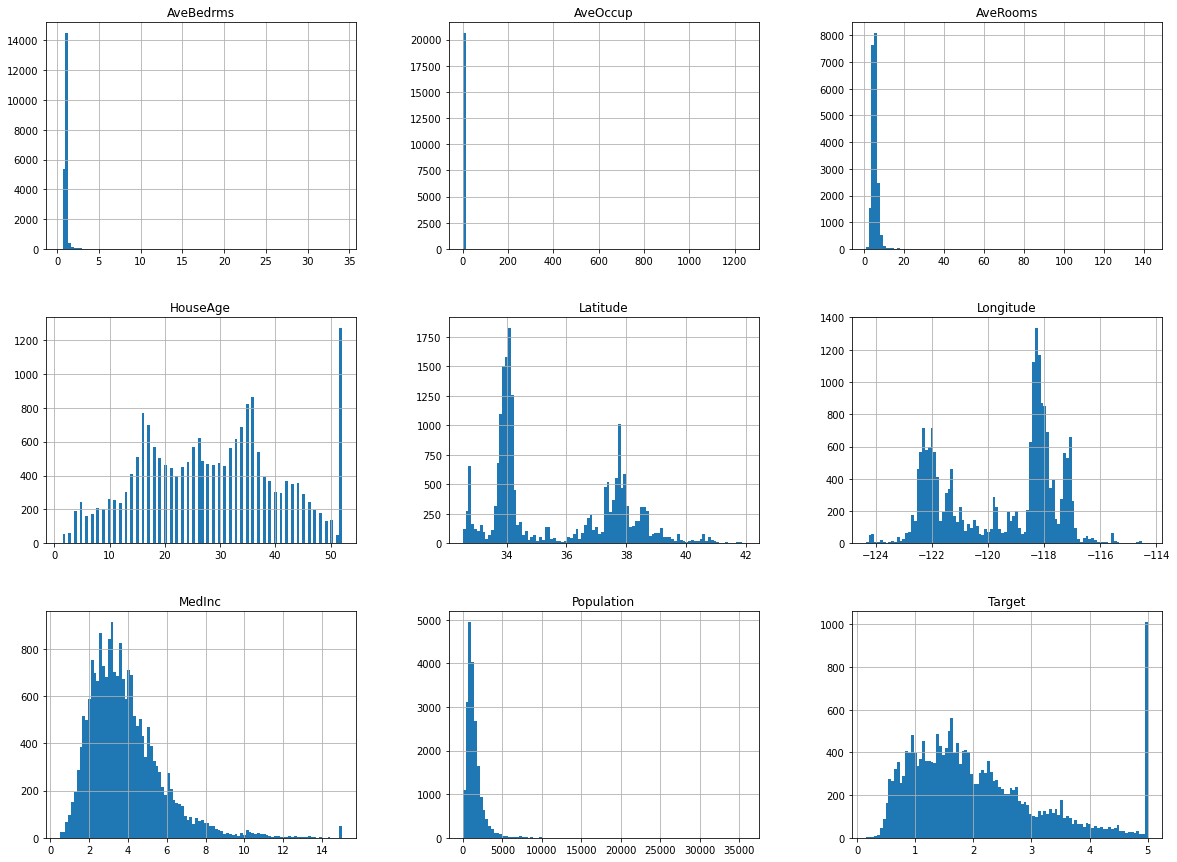

In [0]:
df_total.hist(bins=100, figsize=(20,15))

From the plots it is clear that:
* The attributes have different scales so rescaling is needed
* The targetand median have clear outliers. Those will need to be deleted
* I suppose that the house age have a peak as a result of the fact that houses over a certain age end up getting that maximum number




## Data cleaning

Not giving any model precision increase!

https://www.kaggle.com/manisood001/california-housing-optimised-modelling

In [0]:
#df_total[df_total['Target']>=5]['Target'].value_counts().head()
#df_total[df_total['MedInc']>=15]['MedInc'].value_counts().head()
#df_total=df_total.loc[df_total['Target']<5,:]
#df_total=df_total.loc[df_total['Target']<15,:]

## Feature engineering

Not giving any presition increase either

In [0]:
#df_total['r/b']=df_total['AveRooms']/df_total['AveBedrms']

### Standardize the data

Many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based and gradient-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.

A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

PCA is largely affected by scales as well. Here we have hence decided to use sklearn’s StandardScaler in order to scale the data to zero mean and unit variance.

SOURCES

* https://stats.stackexchange.com/questions/105592/not-normalizing-data-before-pca-gives-better-explained-variance-ratio

* https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html



In [0]:
from sklearn.preprocessing import StandardScaler

def transform1(X):
  x = StandardScaler().fit_transform(X)
  X = pd.DataFrame(x, columns=X.columns)
  return X

def transform2(X,y=None):
    import numpy as np
    from scipy.special import boxcox1p        
    X['AveRooms']=X['AveRooms'].apply(lambda x: boxcox1p(x,0.25))
    X['AveBedrms']=X['AveBedrms'].apply(lambda x: boxcox1p(x,0.25))
    X['HouseAge']=X['HouseAge'].apply(lambda x: boxcox1p(x,0.25))
    X['Population']=X['Population'].apply(lambda x: boxcox1p(x,0.25))
    X['AveOccup']=X['AveOccup'].apply(lambda x: boxcox1p(x,0.25))
    X['Latitude']=X['Latitude'].apply(lambda x: boxcox1p(x,0.25))
    X['MedInc']=X['MedInc'].apply(lambda x: boxcox1p(x,0.25))
    # an offset is needed becouse the data is negative
    X['Longitude']=X['Longitude'].apply(lambda x: boxcox1p(x+125,0.25))
    X['Target']=X['Target'].apply(lambda x: boxcox1p(x,0.25))
    return X

    
df_total = transform2(df_total)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efebfc48ac8>,
      dtype=object)

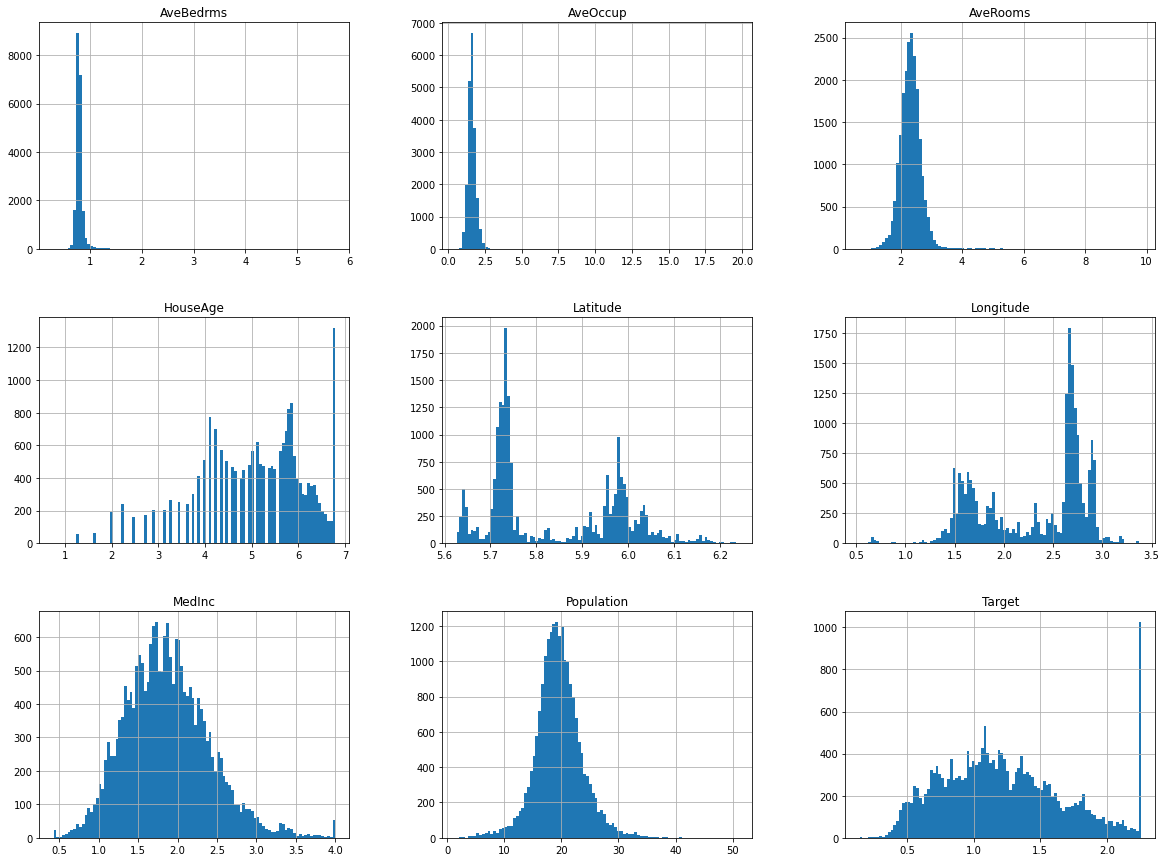

In [0]:
df_total.hist(bins=100, figsize=(20,15))

## Correlation analysis

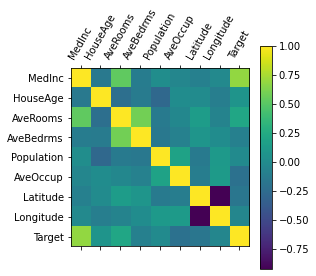

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
MedInc,1.000000,-0.146516,0.527787,-0.110333,0.019547,-0.036270,-0.083011,-0.013237,0.688867
HouseAge,-0.146516,1.000000,-0.219691,-0.119871,-0.273806,0.010693,0.005362,-0.095173,0.075256
AveRooms,0.527787,-0.219691,1.000000,0.591297,-0.131645,-0.027987,0.138555,-0.058171,0.219160
AveBedrms,-0.110333,-0.119871,0.591297,1.000000,-0.151471,-0.076174,0.083644,0.015681,-0.083908
Population,0.019547,-0.273806,-0.131645,-0.151471,1.000000,0.187266,-0.136856,0.116194,-0.003522
AveOccup,-0.036270,0.010693,-0.027987,-0.076174,0.187266,1.000000,-0.109058,0.127576,-0.204878
Latitude,-0.083011,0.005362,0.138555,0.083644,-0.136856,-0.109058,1.000000,-0.920040,-0.165399
Longitude,-0.013237,-0.095173,-0.058171,0.015681,0.116194,0.127576,-0.920040,1.000000,-0.035070
Target,0.688867,0.075256,0.219160,-0.083908,-0.003522,-0.204878,-0.165399,-0.035070,1.000000


In [0]:
corr = df_total.corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=60);
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar()
plt.show()
df_total.corr().style.background_gradient(cmap='coolwarm')

It is clear from this plot that the average number of bedrooms and average number of rooms are somewhat correlated, so both variables move in the same direction by  similar magnitude. This is also true for the median income and the average number of rooms. The longitude and magnitudes is strongly negatively correlated, which means that the variables move in opposite direction by the same magnitude. 

The strongest correlation to the target is the median income for households within a block of houses (measured in tens of thousands of US Dollars). The rest of the signal shows barely any correlation to the target at all.

### Split datat in train and test

We do not apply PCA before the splitting as we would be leaking the information of test data.

In [0]:
from sklearn.model_selection import train_test_split

df_target = df_total.loc[:, df_total.columns == 'Target']
df_data = df_total.loc[:, df_total.columns != 'Target']

xtrain,xtest,ytrain,ytest=train_test_split(df_data,df_target,test_size=0.1,random_state=0)

print('train data shape'+str(xtrain.shape))
print('test data shape'+str(xtest.shape))
print('train target shape'+str(ytrain.shape))
print('test target shape'+str(ytest.shape))

train data shape(18576, 8)
test data shape(2064, 8)
train target shape(18576, 1)
test target shape(2064, 1)


### Checking the importance of features and plot them

As this dataset is not so big we can extract all the components and analyze the percentage of variance by these features (based on: https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)

In [0]:
from sklearn.decomposition import PCA

pcamodel = PCA(8)
pca = pcamodel.fit_transform(xtrain)
print(pca.shape)


# number of components
n_pcs= pcamodel.components_.shape[0]

# get the index of the most important feature of each component
most_important = [np.abs(pcamodel.components_[i]).argmax() for i in range(n_pcs)]

# extract the column names frmo the dataframe
initial_feature_names = df_data.columns.values

# get the names based on the principal component analysis
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# pack the result into a dataframe
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())

print('variance ration of each feature:', pcamodel.explained_variance_ratio_)
print('features:', most_important_names)
print(df)

(18576, 8)
variance ration of each feature: [8.92625262e-01 6.32998236e-02 1.74674815e-02 1.56822277e-02
 5.54535165e-03 4.89672962e-03 3.75417011e-04 1.07706704e-04]
features: ['Population', 'HouseAge', 'MedInc', 'Longitude', 'AveOccup', 'AveRooms', 'AveBedrms', 'Latitude']
     0           1
0  PC0  Population
1  PC1    HouseAge
2  PC2      MedInc
3  PC3   Longitude
4  PC4    AveOccup
5  PC5    AveRooms
6  PC6   AveBedrms
7  PC7    Latitude


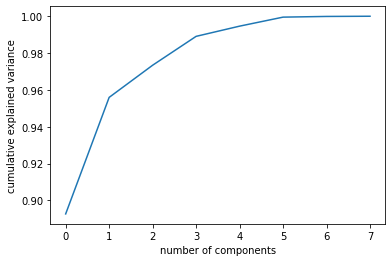

In [0]:
plt.plot(np.cumsum(pcamodel.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that the five first components (PC0, PC1, PC2, PC3, PC4) account for approximately 90% of the variance. That would lead us to believe that using these 5 components, we would maintain most of the essential characteristics of the data.

## 3D Scatter plot of PCA1,PCA2 and PCA3

In [0]:
import plotly.express as px

fig = px.scatter_3d(x=pca[:, 0],
                    y=pca[:, 1],
                    z=pca[:, 2])
fig.update_layout(
    title="PC1 vs PC2 vs PC3",
    scene = dict(xaxis = dict(title='PC1'),
                 yaxis = dict(title='PC2'),
                 zaxis = dict(title='PC3'),)
)

fig.show()

## Effect of variables on each components

The components_ attribute provides principal axes in feature space, representing the directions of maximum variance in the data. This means, we can see influence on each of the components by features.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



[Text(0, 0.5, 'PCA1'),
 Text(0, 1.5, 'PCA2'),
 Text(0, 2.5, 'PCA3'),
 Text(0, 3.5, 'PCA4'),
 Text(0, 4.5, 'PCA5'),
 Text(0, 5.5, 'PCA6'),
 Text(0, 6.5, 'PCA7'),
 Text(0, 7.5, 'PCA8')]

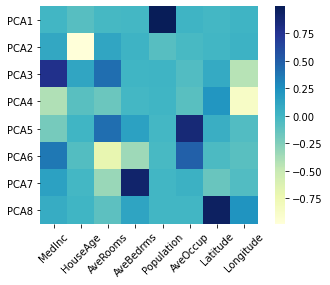

In [0]:
import seaborn as sns

ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=["PCA"+str(x) for x in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(xtrain.columns));
ax.set_aspect("equal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


### Original data VS reduced data

Here we reduce the test data based on the PCA model trained by the training data.

In [0]:
# Compute the components and projected faces
pca = PCA(2).fit(xtrain)
xtraincomponents = pca.transform(xtrain)
xtestcomponents = pca.transform(xtest)
projected = pca.inverse_transform(xtraincomponents)

print("original shape:   ", xtrain.shape)
print("transformed train shape:", xtraincomponents.shape)
print("transformed test shape:", xtestcomponents.shape)

#print('\nthe columns in the data are - \n')
#[print('\t* ', i) for i in df_data.columns.values]
#print('\nthe columns in the target are - \n')
#[print('\t* ', i) for i in components.columns.values]

original shape:    (18576, 8)
transformed train shape: (18576, 2)
transformed test shape: (2064, 2)


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics


# We have created a function to print accuracy metrics which can be used
# to get accuracy metrics of all models in upcoming steps
def print_accuracy_report(y_test, y_pred, X_test, model):
    print('R Squared(Accuracy)', metrics.r2_score(y_test, y_pred))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')


def LinearRegressionModel(xtrain, ytrain, xtest):
    regressor = LinearRegression()
    regressor.fit(xtrain, ytrain)
    ypred = regressor.predict(xtest)
    #for i, values in enumerate(y_test):
    #    print(str(y_pred[i]), str(y_test[i]))
    print_accuracy_report(ytest, ypred, xtest, regressor)
    return regressor


def RandomForestRegressorModel(xtrain, ytrain, xtest):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(xtrain, ytrain)
    ypred = rf.predict(xtest)
    print(print_accuracy_report(ytest, ypred, xtest, rf))
    return rf


print('\t\t-- Linear regression results --')
print('\tWith original data')
LinearRegressionModel(xtrain, ytrain, xtest)
print('\tWith PCA data')
LinearRegressionModel(xtraincomponents, ytrain, xtestcomponents)

print('\t\t-- Random forest results --')
print('\tWith original data')
randomForestModel = RandomForestRegressorModel(xtrain, ytrain, xtest)
print('\tWith PCA data')
randomForestModel = RandomForestRegressorModel(xtraincomponents, ytrain, xtestcomponents)

		-- Linear regression results --
	With original data
R Squared(Accuracy) 0.642378145744567
Mean Absolute Error: 0.21007842215108233
Mean Squared Error: 0.08142657835260234
Root Mean Squared Error: 0.2853534270910415 

	With PCA data
R Squared(Accuracy) 0.0007301996364466046
Mean Absolute Error: 0.38956022026508635
Mean Squared Error: 0.2275227862237282
Root Mean Squared Error: 0.47699348656321106 

		-- Random forest results --
	With original data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



R Squared(Accuracy) 0.8311244825016665
Mean Absolute Error: 0.13287689448559412
Mean Squared Error: 0.038451105249268785
Root Mean Squared Error: 0.1960895337575894 

None
	With PCA data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



R Squared(Accuracy) -0.14340024792453399
Mean Absolute Error: 0.411773378016241
Mean Squared Error: 0.2603397101383872
Root Mean Squared Error: 0.510234955817795 

None


### R2 score based on different types of data tranformations





Just scaling the values to be between 0, 1

    Number of PC chosen | LinearRegression | RandomForest 
    ------------------- | ---------------- | ------------ 
    Original data       | 0.5351261336554  | 0.3348235144

Standardize features by removing the mean and scaling to unit variance

    Number of PC chosen | LinearRegression | RandomForest 
    ------------------- | ---------------- | ------------ 
    Original data       | 0.5943232652466  | 0.7978303716

Boxcox tranformation of features

    Number of PC chosen | LinearRegression | RandomForest 
    ------------------- | ---------------- | ------------ 
    Original data       | 0.642378145744  | 0.83112448250

## Conclusions

The random forest model trained on the boxcox tranformed signals gave the best model with an R2 score of 83. The models trained on the PCA tranformed signals gave a poor result even if the chosen two accounted for ~96% of the data variance.